# Assignment 2 (1 late day)

Welcome to the second assignment! We're excited to see what you'll create using the techniques you've learned in this course.

First of all, please type your name and UID in the following format:

Firstname Lastname, #UID

In [ ]:
#@title Your Info { display-mode: "form" }

Name = 'Alexander Chien'  #@param {type:"string"}
UID = '405987063'  #@param {type:"string"}

### Goals
The goals of this assignment are to:

1. Build and train a convolutional neural network from scratch and using built-in PyTorch modules.
2. Build ResNet-18 from scarch and Finetune it different strategies.
3. Visualize the attention of ResNet using Class Activation Mapping
4. Come up with your own model and compete on a test leaderboard for extra credit.

By the end of this assignment, you will have gained experience with:

- Implementing and training cnns using PyTorch.
- Designing you own neural networks with the tips and tricks
- Debugging and troubleshooting issues that may arise during the development process.

Please note that it may take some time to run the entire notebook and prepare the submission version. Make sure to allocate enough time for this task and start early. If you have any questions or run into any issues, please feel free to raise them in the Piazza forum or search the internet for debugging purposes. However, please do not directly copy code from other sources.

This assignment is due on **Sunday, Feb 11th**.

**Do not use any Code AI to finish the assignment.**


Good luck and happy coding! Remember, the most important thing is to have fun and learn something new.





## Q0: Data Preparation(0 pts)

As in Assignment 1, we first download the MiniPlaces dataset and upload it to Colab using the following codes.

Note that everytime you open up this notebook, we will need to **re-download and process the dataset**. Don't worry though - this shouldn't take long, usually just a minute or less. Okay, let's get started!

To begin, you will need to download the Miniplaces Dataset from its google drive file ID.

Downloading this dataset typically takes less than 15 seconds.

In [2]:
# Downloading this file takes about a few seconds.
# Download the tar.gz file from google drive using its file ID.
!pip3 install --upgrade gdown --quiet
# unfortunately, only the following command seems to be constantly working...
!wget https://web.cs.ucla.edu/~smo3/data.tar.gz


--2024-02-26 20:21:59--  https://web.cs.ucla.edu/~smo3/data.tar.gz
Resolving web.cs.ucla.edu (web.cs.ucla.edu)... 131.179.128.29
Connecting to web.cs.ucla.edu (web.cs.ucla.edu)|131.179.128.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460347416 (439M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 439.02M  19.2MB/s    in 24s     

2024-02-26 20:22:24 (18.3 MB/s) - ‘data.tar.gz’ saved [460347416/460347416]



In the following code, we setup the root directory for our project, extract the dataset to the root directory, and download the label files.

In [3]:
import os

# Let's make our assignment directory
CS188_path = './CS188_W24'
os.makedirs(os.path.join(CS188_path, 'Assignment2', 'data'), exist_ok=True)
# os.makedirs will create directories recursively, i.e., it will create the
# directories and any missing parent directories if they do not exist.

# Now, let's specify the assignment path we will be working with as the root.
root_dir = os.path.join(CS188_path, 'Assignment2')

import os
import tarfile
import urllib.request
from tqdm import tqdm


def setup(file_link_dict={}):
    # Open the tar.gz file
    tar = tarfile.open("data.tar.gz", "r:gz")
    # Extract the file "./Assignment2/data" folder
    total_size = sum(f.size for f in tar.getmembers())
    with tqdm(total=total_size,
              unit="B",
              unit_scale=True,
              desc="Extracting tar.gz file") as pbar:
        for member in tar.getmembers():
            tar.extract(member, os.path.join(root_dir, 'data'))
            pbar.update(member.size)
    # Close the tar.gz file
    tar.close()

    # Next, we download the train/val/test txt files:
    for file_name, file_link in file_link_dict.items():
        print(f'Downloding {file_name}.txt from {file_link}')
        urllib.request.urlretrieve(file_link,
                                   f'{root_dir}/data/{file_name}.txt')


val_url = 'https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/val.txt'
train_url = 'https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/train.txt'
setup(file_link_dict={'train': train_url, 'val': val_url}, )

Extracting tar.gz file: 100%|██████████| 566M/566M [00:35<00:00, 16.0MB/s]


Downloding train.txt from https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/train.txt
Downloding val.txt from https://raw.githubusercontent.com/CSAILVision/miniplaces/master/data/val.txt


Also, it is a good habit to setup the seed before running any experiment to ensure reproducibility.

In [4]:
# Also, seed everything for reproducibility
# code from https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964#file-seed_everything-py
def seed_everything(seed: int):
    import os
    import random

    import numpy as np
    import torch
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(0)

In the following, fill in the PyTorch MiniPlaces dataset you implemented in Assignment 1(we will release the key for A1 after it's due.)
Since, we will be focused on convolutional neural networks for this assignment, **there's no need to flatten the image to a vector**. In addition, to fully utilize the modelling power of convolutional neural networks, we will not downsample the image and use its original size. Therefore, the output size of the image tensor should be $[3, 128, 128]$, please update the image transformation in the codeblock below

In [ ]:
import torch
from PIL import Image
from torchvision import transforms

image_net_mean = torch.Tensor([0.485, 0.456, 0.406])
image_net_std = torch.Tensor([0.229, 0.224, 0.225])
# Define data transformation
data_transform = transforms.Compose([
    ################# Your Implementations #####################################
    # TODO: Resize image to 128x128,
    transforms.Resize((128, 128)),
    ################# End of your Implementations ##############################
    transforms.ToTensor(),

    ################# Your Implementations #####################################
    # TODO: Normalize image using ImageNet statistics
    transforms.Normalize(mean=image_net_mean, std=image_net_std),
    ################# End of your Implementations ##############################
])

Also, we will be using the same Pytorch dataset definition in A1, just copy your implementations here:

In [ ]:
import os

from torch.utils.data import DataLoader, Dataset


class MiniPlaces(Dataset):

    def __init__(self, root_dir, split, transform=None, label_dict=None):
        """
        Initialize the MiniPlaces dataset with the root directory for the images,
        the split (train/val/test), an optional data transformation,
        and an optional label dictionary.

        Args:
            root_dir (str): Root directory for the MiniPlaces images.
            split (str): Split to use ('train', 'val', or 'test').
            transform (callable, optional): Optional data transformation to apply to the images.
            label_dict (dict, optional): Optional dictionary mapping integer labels to class names.
        """
        assert split in ['train', 'val', 'test']
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.filenames = []
        self.labels = []

        # Take a second to think why we need this line.
        # Hints: training set / validation set / test set.
        self.label_dict = label_dict if label_dict is not None else {}

        # You should
        #   1. Load the train/val/test text file based on the `split` argument and
        #     store the image filenames and labels.
        #   2. Extract the class names from the image filenames and store them in
        #     self.label_dict.
        #   3. Construct a label dict that maps integer labels to class names, if
        #     the current split is "train"
        ################# Your Implementations #################################
        self.root_dir = os.path.join(root_dir, 'images')
        file_path = os.path.join(root_dir, f'{split}.txt')
        with open(file_path, 'r') as file:
          for line in file:
            filename, label = line.strip().split()
            label = int(label)

            # Map label to class names (for training)
            if split == 'train':
              # Extract class name
              parts = filename.split('/')
              class_name = parts[2]
              if label not in self.label_dict:
                self.label_dict[label] = class_name
            else:
              # Map filenames to class names (for validation or test)
              if filename not in self.label_dict:
                self.label_dict[filename] = label


            self.filenames.append(filename)
            self.labels.append(int(label))
        ################# End of your Implementations ##########################

    def __len__(self):
        """
        Return the number of images in the dataset.

        Returns:
            int: Number of images in the dataset.
        """
        dataset_len = 0
        ################# Your Implementations #################################
        # Return the number of images in the dataset
        dataset_len = len(self.filenames)
        ################# End of your Implementations ##########################
        return dataset_len

    def __getitem__(self, idx):
        """
        Return a single image and its corresponding label when given an index.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            tuple: Tuple containing the image and its label.
        """
        ################# Your Implementations #################################
        # Load and preprocess image using self.root_dir,
        # self.filenames[idx], and self.transform (if specified)
        image_path = os.path.join(self.root_dir, self.filenames[idx])
        image = Image.open(image_path)
        if self.transform is not None:
          image = self.transform(image)
        label = self.labels[idx]
        ################# End of your Implementations ##########################
        return image, label


data_root = os.path.join(root_dir, 'data')
# Create MiniPlaces dataset object
miniplaces_train = MiniPlaces(data_root,
                              split='train',
                              transform=data_transform)

miniplaces_val = MiniPlaces(data_root,
                            split='val',
                            transform=data_transform,
                            label_dict=miniplaces_train.label_dict)

# Create the dataloaders
# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Create DataLoader for training and validation sets
train_loader = DataLoader(miniplaces_train,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          shuffle=True)
val_loader = DataLoader(miniplaces_val,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=False)


Then, define the training and evaluation functions to train and test the CNN (Same as Assignment 1, You don't need to modify this part):

In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, device,
          num_epochs):
    """
    Train the MLP classifier on the training set and evaluate it on the validation set every epoch.

    Args:
        model (MLP): MLP classifier to train.
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        criterion (callable): Loss function to use for training.
        device (torch.device): Device to use for training.
        num_epochs (int): Number of epochs to train the model.
    """
    # Place model on device
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        # Use tqdm to display a progress bar during training
        with tqdm(total=len(train_loader),
                  desc=f'Epoch {epoch + 1}/{num_epochs}',
                  position=0,
                  leave=True) as pbar:
            for inputs, labels in train_loader:
                # Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out gradients
                optimizer.zero_grad()

                # Compute the logits and loss
                logits = model(inputs)
                loss = criterion(logits, labels)

                # Backpropagate the loss
                loss.backward()

                # Update the weights
                optimizer.step()

                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())

        # Evaluate the model on the validation set
        avg_loss, accuracy = evaluate(model, val_loader, criterion, device)
        print(
            f'Validation set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}'
        )


def evaluate(model, test_loader, criterion, device):
    """
    Evaluate the MLP classifier on the test set.

    Args:
        model (MLP): MLP classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.

    Returns:
        float: Average loss on the test set.
        float: Accuracy on the test set.
    """
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0

        for inputs, labels in test_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Compute the logits and loss
            logits = model(inputs)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Compute the accuracy
            _, predictions = torch.max(logits, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(inputs)

    # Compute the average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = num_correct / num_samples

    return avg_loss, accuracy

In [11]:
import torch
import torch.nn.functional as F

# Define the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

# if not torch.backends.mps.is_available():
#     if not torch.backends.mps.is_built():
#         print("MPS not available because the current PyTorch install was not "
#               "built with MPS enabled.")
#     else:
#         print("MPS not available because the current MacOS version is not 12.3+ "
#               "and/or you do not have an MPS-enabled device on this machine.")

# else:
#     mps_device = torch.device("mps")

#     # Create a Tensor directly on the mps device
#     x = torch.ones(5, device=mps_device)
#     # Or
#     x = torch.ones(5, device="mps")

#     # Any operation happens on the GPU
#     y = x * 2

#     # Move your model to mps just like any other device
#     model = YourFavoriteNet()
#     model.to(mps_device)

#     # Now every call runs on the GPU
#     pred = model(x)

Good to go!


Let's setting up the device, Assignment 2 involves much more computaton than Assignment 1, and hence using a GPU is preferred

In [ ]:
# This line of code gives you the information about GPU
! nvidia-smi

Mon Feb 12 03:47:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Q1: Convolutional Neural Network (CNN) (30 pts)

In this question, you will learn how to implement convolutional neural networks (CNNs) using PyTorch.

Similarly as Q2, we will first build a two-layer convolutional neural networks using PyTorch built-in function `nn.Conv2D` and then build the convolution operation from scratch.

### Q1.1 Fast Conv (10 pts)

Fill in the code below to implement a simple CNN similar to the MLP we built in A1, we can use built-in PyTorch Operations (e.g `nn.conv2d`) to build the network.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FastConv(nn.Module):

    def __init__(self,
                 input_channels,
                 conv_hidden_channels,
                 conv_out_channels,
                 input_size=(64, 64),
                 dropout_rate1=0.25,
                 dropout_rate2=0.5,
                 fc_out_channels=128,
                 num_classes=100,
                 kernel_size=3,
                 stride=2,
                 padding=1):
        """
        Args:
          input_channels (int): Number of channels in the input image.
          conv_hidden_channels (int): Number of channels in the first convolutional layer.
          conv_out_channels (int): Number of channels in the second convolutional layer.
          input_size (tuple, optional): Height and width of the input image. (default: (64,64))
          dropout_rate1, dropout_rate2 (float, optional): Dropout rate for
              the first/second dropout layer. (default: 0.25, 0.5)
          fc_out_channels (int, optional): Number of neurons in the first fully
              connected layer. (default: 128)
          num_classes (int, optional): Number of classes in the final output layer. (default: 100)
          kernel_size, stride, padding (int, optional): Parameters of convolutional layers.

        Initialize a convolutional neural network.
        You can use Pytorch's built-in functions like, nn.Conv2d, nn.MaxPool2d, etc.
        Input and output shapes of each layer:
        1) conv1: (batch_size, input_channels, H, W) -> (batch_size, conv_hidden_channels, H//2, W//2)
        2) conv2: (batch_size, conv_hidden_channels, H//2, W//2) -> (batch_size, conv_out_channels, H//4, W//4)
        3) max_pooling: (batch_size, conv_out_channels, H//8, W//8)
        4) fc1: (batch_size, flatten_size) -> (batch_size, fc_out_channels)
        5) fc2: (batch_size, fc_out_channels) -> (batch_size, num_classes)
        """
        super().__init__()

        self.conv1 = None
        self.conv2 = None
        self.max_pooling = None
        self.dropout1 = None
        self.dropout2 = None
        self.fc1 = None
        self.fc2 = None
        ################# Your Implementations #################################
        # TODO: Define the layers of the convolutional neural network
        # replace "None"s with your implementations.
        # All you need to do is to pass the input arguments to different constructors
        self.conv1 = nn.Conv2d(input_channels, conv_hidden_channels, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(conv_hidden_channels, conv_out_channels, kernel_size, stride, padding)
        self.max_pooling = nn.MaxPool2d(kernel_size, stride, padding)
        self.dropout1 = nn.Dropout(dropout_rate1)

        height, width = input_size
        flatten_size = conv_out_channels * (height // 8) * (width // 8)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(flatten_size, fc_out_channels)
        self.dropout2 = nn.Dropout(dropout_rate2)
        self.fc2 = nn.Linear(fc_out_channels, num_classes)

        ################# End of your Implementations ##########################

    def forward(self, x, return_intermediate=False):
        """
        Forward pass of the convolutional neural network.
        The input tensor 'x' should pass through the following layers:
        1) conv1: (batch_size, input_channels, H, W) -> (batch_size, conv_hidden_channels, H, W)
        2) Apply relu.
        3) conv2: (batch_size, conv_hidden_channels, H, W) -> (batch_size, conv_out_channels, H, W)
        4) max_pooling: Perform max pooling on the output from conv2
        5) dropout1: Perform dropout on the output from max_pooling
        6) Flatten the output from dropout1
        7) fc1: Pass through a fully connected layer
        8) dropout2: Perform dropout on the output from fc1
        9) Apply relu.
        7) fc2: Pass the output from the actiction layer to through a fully connected
                layer to produce the final output
        """
        ################# Your Implementations #################################
        # TODO: Implement the forward pass of the convolutional neural network
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.max_pooling(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = F.relu(x)
        x = self.fc2(x)

        ################# End of your Implementations ##########################
        return x

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = FastConv(input_channels=3,
                 conv_hidden_channels=64,
                 conv_out_channels=128,
                 input_size=(128, 128),
                 dropout_rate1=0.25,
                 dropout_rate2=0.5,
                 fc_out_channels=128,
                 kernel_size=3,
                 stride=2,
                 padding=1,
                 num_classes=len(miniplaces_train.label_dict))

# Let's use the built-in optimizer for a full version of SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# For loss function, your implementation and the built-in loss function should
# be almost identical.
criterion = nn.CrossEntropyLoss()

# Train the model
train(model,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

Epoch 1/5: 100%|██████████| 1563/1563 [01:47<00:00, 14.54it/s, loss=3.84]


Validation set: Average loss = 3.5708, Accuracy = 0.1434


Epoch 2/5: 100%|██████████| 1563/1563 [01:38<00:00, 15.95it/s, loss=4.26]


Validation set: Average loss = 3.4064, Accuracy = 0.1810


Epoch 3/5: 100%|██████████| 1563/1563 [01:35<00:00, 16.29it/s, loss=3.6]


Validation set: Average loss = 3.4305, Accuracy = 0.1789


Epoch 4/5: 100%|██████████| 1563/1563 [01:36<00:00, 16.24it/s, loss=3.24]


Validation set: Average loss = 3.2997, Accuracy = 0.1932


Epoch 5/5: 100%|██████████| 1563/1563 [01:36<00:00, 16.22it/s, loss=3.27]


Validation set: Average loss = 3.3613, Accuracy = 0.1809


You should get around 14.93% accuracy after the first epoch and 18.27% accuracy after five epochs, which is a huge improvement from using MLPs.

### Q1.2 Building 2D Convolutional layer from sratch (20pts)

Next, we will build convolutional neural networks from scratch.


Let's ignore channels for now and see how this works with two-dimensional data had hidden representations. In the following figure, the input is a two-dimensional tensor with hegith of 3 and width of 3. We mark the shape of the tensor as $3\times3$. The height and width of the kernel are both 2. The shape of the kernel window (or convolution window) is given by the height and width of the kernel (here it is $2\times2$).

![correlation](https://web.cs.ucla.edu/~smo3/cs188/assignment2/correlation.png)


In the two-dimensional convolution operation, we begin with the convolution window position at the upper-left corner of the input tensor and slide it across the intput tensor, both from left to right and top to bottom. When the convolution window slides to a certain position, the input subtensor contained in that window and the kernel tensor are multiplied elementwise and the resulting tensor is summed up yielding a single scalar value. This result gives the value of the output tensor at the corresponding location. Here, the output tensor has a height of 2 and width of 2 and the four elements are derived from the two-dimensional cross-correlation operation:
$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$

Note that along each axis, the output size
is slightly smaller than the input size.
Because the kernel has width and height greater than one,
we can only properly compute the cross-correlation
for locations where the kernel fits wholly within the image,
the output size is given by the input size $n_h \times n_w$
minus the size of the convolution kernel $k_h \times k_w$
via

$$(n_h-k_h+1) \times (n_w-k_w+1).$$

This is the case since we need enough space
to "shift" the convolution kernel across the image.

#### Q1.2.1 One Channel Convolution (5pts)
That's start with 2D convolution with only 1 input channel and 1 kernel.
If your implementation is right, you'll get:
```
tensor([[19., 25.],
        [37., 43.]])
```

In [ ]:
def conv2d(X, K):
    """
    Compute 2D convolution. You are supposed to use matrix multiplication
    to achieve the 2D convolution instead of torch build in convolution method.

        Args:
          X (tensor): Input tensor in the shape of (n_h,n_w).
          K (tensor): Kernel tensor in the shape of (k_h,k_w).

        Return:
          Y (tensor): Output tensor in the shape of (H,W).

    """
    Y = None
    ################# Your Implementations #####################################
    # Hint: Using two for loops
    n_h, n_w = X.shape
    k_h, k_w = K.shape
    Y_h = n_h - k_h + 1
    Y_w = n_w - k_w + 1
    Y = torch.zeros((Y_h, Y_w))

    for i in range(Y_h):
      for j in range(Y_w):
        Y[i, j] = torch.sum(X[i:i+k_h, j:j+k_w] * K)

    ################# End of your Implementations ##############################
    return Y

In [ ]:
# Try to debug using this code segment:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
conv2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

#### Q1.2.2  One Channel Convolution with Padding and Stride (5pts)

Since we typically use small kernels,
for any given convolution,
we might only lose a few pixels,
but this can add up as we apply
many successive convolutional layers.
One straightforward solution to this problem
is to add extra pixels of filler around the boundary of our input image,
thus increasing the effective size of the image.
Typically, we set the values of the extra pixels to zero.
In the following image, we pad a $3 \times 3$ input,
increasing its size to $5 \times 5$.
The corresponding output then increases to a $4 \times 4$ matrix.
The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times0+0\times1+0\times2+0\times3=0$.

![Two-dimensional cross-correlation with padding.](https://web.cs.ucla.edu/~smo3/cs188/assignment2/conv-pad.png)

In general, if we add a total of $p_h$ rows of padding
(roughly half on top and half on bottom)
and a total of $p_w$ columns of padding
(roughly half on the left and half on the right),
the output shape will be

$$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1).$$

This means that the height and width of the output
will increase by $p_h$ and $p_w$, respectively.

In many cases, we will want to set $p_h=k_h-1$ and $p_w=k_w-1$
to give the input and output the same height and width.
This will make it easier to predict the output shape of each layer
when constructing the network.

When computing the cross-correlation,
we start with the convolution window
at the upper-left corner of the input tensor,
and then slide it over all locations both down and to the right.
In the previous examples, we defaulted to sliding one element at a time.
However, sometimes, either for computational efficiency
or because we wish to downsample,
we move our window more than one element at a time,
skipping the intermediate locations. This is particularly useful if the convolution
kernel is large since it captures a large area of the underlying image.

We refer to the number of rows and columns traversed per slide as *stride*.
So far, we have used strides of 1, both for height and width.
Sometimes, we may want to use a larger stride.
The following image shows a two-dimensional cross-correlation operation
with a stride of 3 vertically and 2 horizontally.
The shaded portions are the output elements as well as the input and kernel tensor elements used for the output computation: $0\times0+0\times1+1\times2+2\times3=8$, $0\times0+6\times1+0\times2+0\times3=6$.
We can see that when the second element of the first column is generated,
the convolution window slides down three rows.
The convolution window slides two columns to the right
when the second element of the first row is generated.
When the convolution window continues to slide two columns to the right on the input,
there is no output because the input element cannot fill the window
(unless we add another column of padding).

![Cross-correlation with strides of 3 and 2 for height and width, respectively.](https://web.cs.ucla.edu/~smo3/cs188/assignment2/conv-stride.png)

In general, when the stride for the height is $s_h$
and the stride for the width is $s_w$, the output shape is

$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$



In the next cell, you will need to add padding and stride to the conv2d function.

If your implementation is right, the correct output is
```
tensor([[19., 31.],
        [50., 62.]])
```

In [ ]:
def conv2d_padding_stride(X, K, padding=0, stride=0):
    """Compute 2D convolution with stride. Here the stride applied both
       horizontally and vertically.

        Args:
          X (tensor): Input tensor in the shape of (n_h,n_w).
          K (tensor): Kernel tensor in the shape of (k_h,k_w).
          padding (int): padding in both dimensions (p_h, p_w).
          stride (int): Stride in both dimensions (s_h, s_w).

        Return:
          Y (tensor): Output tensor in the shape of (H,W)
    """
    Y = None
    ################# Your Implementations #####################################
    n_h, n_w = X.shape
    k_h, k_w = K.shape
    Y_h = (n_h - k_h + 2 * padding + stride) // stride
    Y_w = (n_w - k_w + 2 * padding + stride) // stride
    X_padded = F.pad(X, (padding, padding, padding, padding))
    Y = torch.zeros((Y_h, Y_w))

    for i in range(Y_h):
      for j in range(Y_w):
        start_h = i * stride
        start_v = j * stride
        Y[i, j] = torch.sum(X_padded[start_h:start_h+k_w, start_v:start_v+k_h] * K)
    ################# End of your Implementations ##############################
    return Y

In [ ]:
# Try to debug using this code segment:
X = torch.tensor([[0.0, 1.0, 2.0, 3.0], [3.0, 4.0, 5.0, 6.0],
                  [6.0, 7.0, 8.0, 9.0], [8.0, 9.0, 10.0, 11.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
conv2d_padding_stride(X, K, padding=0, stride=2)

tensor([[19., 31.],
        [50., 62.]])

#### Q1.2.3 Multiple Channels 2D Convlution (5pts)
When the input data contains multiple channels,
we need to construct a convolution kernel
with the same number of input channels as the input data,
so that it can perform cross-correlation with the input data.
Assuming that the number of channels for the input data is $c_i$,
the number of input channels of the convolution kernel also needs to be $c_i$. If our convolution kernel's window shape is $k_h\times k_w$,
then when $c_i=1$, we can think of our convolution kernel
as just a two-dimensional tensor of shape $k_h\times k_w$.

However, when $c_i>1$, we need a kernel
that contains a tensor of shape $k_h\times k_w$ for *every* input channel. Concatenating these $c_i$ tensors together
yields a convolution kernel of shape $c_i\times k_h\times k_w$.
Since the input and convolution kernel each have $c_i$ channels,
we can perform a cross-correlation operation
on the two-dimensional tensor of the input
and the two-dimensional tensor of the convolution kernel
for each channel, adding the $c_i$ results together
(summing over the channels)
to yield a two-dimensional tensor.
This is the result of a two-dimensional cross-correlation
between a multi-channel input and
a multi-input-channel convolution kernel.

The following image provides an example
of a two-dimensional cross-correlation with two input channels.
The shaded portions are the first output element
as well as the input and kernel tensor elements used for the output computation:
$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$.

![Cross-correlation computation with 2 input channels.](https://web.cs.ucla.edu/~smo3/cs188/assignment2/conv-multi-in.png)


To make sure we really understand what is going on here,
we can (**implement cross-correlation operations with multiple input channels**) ourselves.
Notice that all we are doing is performing a cross-correlation operation
per channel and then adding up the results.

Then, we'll consider the cases where there are multiple input channels. If your implementation is right, the correct output is


```
tensor([[  4.,  26.,  18.],
        [ 57., 120.,  55.],
        [ 29.,  46.,  13.]])
```



In [ ]:
def conv2d_multi_in(X, K, padding=0, stride=0) -> torch.tensor:
    """Compute 2D cross-correlation with multiple input channels.
        Here, X and K should have the same chanel number

        Args:
          X (tensor): Input tensor in the shape of (in_Channels,n_h,n_w).
          K (tensor): Kernel tensor (in_Channels,k_h,k_w)
          padding (int): padding in H,W dimensions (p_h, p_w).
          stride (int): Stride in H,W dimensions (s_h, s_w).

        Return:
          Y (tensor): Output tensor in the shape of (H,W)

    """
    # Hint： Iterate through the 0th dimension (channel) of K first, then stack them up, then take the sum
    Y = None
    ################# Your Implementations #####################################
    channels, n_h, n_w = X.shape
    _, k_h, k_w = K.shape
    Y_h = (n_h - k_h + 2 * padding) // stride + 1
    Y_w = (n_w - k_w + 2 * padding) // stride + 1
    X_padded = F.pad(X, (padding, padding, padding, padding))
    tensors = torch.zeros((channels, Y_h, Y_w))
    Y = torch.zeros((Y_h, Y_w))

    for channel in range(channels):
      for i in range(Y_h):
        for j in range(Y_w):
          start_row = i * stride
          start_col = j * stride
          end_row = start_row + k_h
          end_col = start_col + k_w
          tensors[channel, i, j] = torch.sum(X_padded[channel, start_row:end_row, start_col:end_col] * K[channel, :, :])
    Y = torch.sum(tensors, dim=0)

    ################# End of your Implementations ##############################
    return Y

In [ ]:
# Try to debug using this code segment:
X = torch.tensor([[[0.0, 1.0, 2.0, 3.0], [3.0, 4.0, 5.0, 6.0],
                   [6.0, 7.0, 8.0, 9.0], [9.0, 10.0, 11.0, 12.0]],
                  [[1.0, 2.0, 3.0, 4.0], [4.0, 5.0, 6.0, 7.0],
                   [7.0, 8.0, 9.0, 10.0], [10.0, 11.0, 12.0, 13.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

out = conv2d_multi_in(X, K, padding=1, stride=2)
out

tensor([[  4.,  26.,  18.],
        [ 57., 120.,  55.],
        [ 29.,  46.,  13.]])

In [ ]:
# Compare our method with torch build-in method
X = (torch.rand(2, 10, 10)).to(torch.float32)
K = (torch.rand(2, 3, 3)).to(torch.float32)
for i in [1, 2, 3, 4, 5]:
    for j in [1, 2, 3, 4, 5]:
        out = conv2d_multi_in(X, K, padding=i, stride=j)
        answer = F.conv2d(X.unsqueeze(0), K.unsqueeze(0), stride=j,
                          padding=i).squeeze(0).squeeze(0)
        equal = torch.allclose(out, answer)

        if equal:
            print('Good! For padding: %d and stride: %d, the output match' %
                  (i, j))
        else:
            print('Uh-oh! The output are different')
            break

Good! For padding: 1 and stride: 1, the output match
Good! For padding: 1 and stride: 2, the output match
Good! For padding: 1 and stride: 3, the output match
Good! For padding: 1 and stride: 4, the output match
Good! For padding: 1 and stride: 5, the output match
Good! For padding: 2 and stride: 1, the output match
Good! For padding: 2 and stride: 2, the output match
Good! For padding: 2 and stride: 3, the output match
Good! For padding: 2 and stride: 4, the output match
Good! For padding: 2 and stride: 5, the output match
Good! For padding: 3 and stride: 1, the output match
Good! For padding: 3 and stride: 2, the output match
Good! For padding: 3 and stride: 3, the output match
Good! For padding: 3 and stride: 4, the output match
Good! For padding: 3 and stride: 5, the output match
Good! For padding: 4 and stride: 1, the output match
Good! For padding: 4 and stride: 2, the output match
Good! For padding: 4 and stride: 3, the output match
Good! For padding: 4 and stride: 4, the output

Then, we'll consider the cases where there are multiple input channels and multiple output channels. We will be also adding a bias tensor $B$ on each output channel. Notice the input tensor X has a batch demension.

In [ ]:
def batched_conv2d_multi_in_out(X, K, B, padding=0, stride=0) -> torch.tensor:
    """Compute 2D cross-correlation with multiple input channels and multiple
        output channels.

        Args:
          X (tensor): Input tensor in the shape of (batch_size,in_channels,n_h,n_w).
          K (tensor): Kernel tensor (out_channels,in_channels,k_h,k_w).
          B (tensor): Bias tensor (out_channels)
          padding (int): padding in H,W dimensions (p_h, p_w).
          stride (int): Stride in H,W dimensions (s_h, s_w).

        Return:
          Y (tensor): Output tensor in the shape of (batch_size,out_channels,H,W)

    """
    # Hint: Loop though the batch dimension and then loop though the out_channel
    #       dimension
    Y = None
    ################# Your Implementations #####################################
    batch_size, in_channels, n_h, n_w = X.shape
    out_channels, _, k_h, k_w = K.shape
    Y_h = (n_h - k_h + 2 * padding) // stride + 1
    Y_w = (n_w - k_w + 2 * padding) // stride + 1

    X_padded = F.pad(X, (padding, padding, padding, padding))
    Y = torch.zeros((batch_size, out_channels, Y_h, Y_w), dtype=X.dtype, device=X.device)

    # For each batch of input
    for batch in range(batch_size):
      # For each kernel of size in_channels x H x W
      for out_channel in range(out_channels):
        # Same computation as before: sum up tensors of all inner channels after convolutions
        tensors = torch.zeros((in_channels, Y_h, Y_w))
        for in_channel in range(in_channels):
          for i in range(Y_h):
            for j in range(Y_w):
              start_row = i * stride
              start_col = j * stride
              end_row = start_row + k_h
              end_col = start_col + k_w
              Y[batch, out_channel, i, j] += torch.sum(X_padded[batch, in_channel, start_row:end_row, start_col:end_col] * K[out_channel, in_channel])
        # Add bias term
        Y[batch, out_channel] += B[out_channel]


    ################# End of your Implementations ##############################
    return Y

In [ ]:
# Compare our method with torch build-in method
X = (torch.rand(2, 2, 10, 10)).to(torch.float32)
K = (torch.rand(2, 2, 3, 3)).to(torch.float32)
B = (torch.rand(2)).to(torch.float32)
for i in [1, 2, 3, 4, 5]:
    for j in [1, 2, 3, 4, 5]:
        out = batched_conv2d_multi_in_out(X, K, B, padding=i, stride=j)
        answer = F.conv2d(X, K, B, stride=j, padding=i)
        equal = torch.allclose(out, answer)

        if equal:
            print('Good! For padding: %d and stride: %d, the output match' %
                  (i, j))
        else:
            print('Uh-oh! The output are different')
            break

Good! For padding: 1 and stride: 1, the output match
Good! For padding: 1 and stride: 2, the output match
Good! For padding: 1 and stride: 3, the output match
Good! For padding: 1 and stride: 4, the output match
Good! For padding: 1 and stride: 5, the output match
Good! For padding: 2 and stride: 1, the output match
Good! For padding: 2 and stride: 2, the output match
Good! For padding: 2 and stride: 3, the output match
Good! For padding: 2 and stride: 4, the output match
Good! For padding: 2 and stride: 5, the output match
Good! For padding: 3 and stride: 1, the output match
Good! For padding: 3 and stride: 2, the output match
Good! For padding: 3 and stride: 3, the output match
Good! For padding: 3 and stride: 4, the output match
Good! For padding: 3 and stride: 5, the output match
Good! For padding: 4 and stride: 1, the output match
Good! For padding: 4 and stride: 2, the output match
Good! For padding: 4 and stride: 3, the output match
Good! For padding: 4 and stride: 4, the output

#### Q1.2.4 Try your own implementation (5pts)

In the next task, you will implement your own 2D convolution neural network with the custom convolution operator you just wrote.

This task should be relatively straightforward. Just to pay attention to shape of the weights and biases of the convolution.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CustomConv2d(torch.nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0):
        super(CustomConv2d, self).__init__()
        # Initialize weights using random initialization with 0.01 std
        # Initialize bias using zero initialization
        # Save the stride and padding info
        ################# Your Implementations #################################
        self.stride = stride
        self.padding = padding
        self.bias = nn.Parameter(torch.zeros(out_channels))
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.01)
        ################# End of your Implementations ##########################

    def forward(self, x):
        # call your implemented function batched_conv2d_multi_in_out/or F.conv2d here
        ################# Your Implementations #################################
        return batched_conv2d_multi_in_out(x, self.weight, self.bias, padding=self.padding, stride=self.stride)
        ################# End of your Implementations ##########################


class CustomConv(nn.Module):

    def __init__(self,
                 input_channels,
                 conv_hidden_channels,
                 conv_out_channels,
                 input_size=(64, 64),
                 dropout_rate1=0.25,
                 dropout_rate2=0.5,
                 fc_out_channels=128,
                 num_classes=100,
                 kernel_size=3,
                 stride=2,
                 padding=1):
        """
        Args:
          input_channels (int): Number of channels in the input image.
          conv_hidden_channels (int): Number of channels in the first convolutional layer.
          conv_out_channels (int): Number of channels in the second convolutional layer.
          input_size (tuple, optional): Height and width of the input image. (default: (64,64))
          dropout_rate1, dropout_rate2 (float, optional): Dropout rate for
              the first/second dropout layer. (default: 0.25, 0.5)
          fc_out_channels (int, optional): Number of neurons in the first fully
              connected layer. (default: 128)
          num_classes (int, optional): Number of classes in the final output layer. (default: 100)
          kernel_size, stride, padding (int, optional): Parameters of convolutional layers.

        Initialize a convolutional neural network.
        You should use your own convolution operator CustomConv2d.
        Input and output shapes of each layer:
        1) conv1: (batch_size, input_channels, H, W) -> (batch_size, conv_hidden_channels, H, W)
        2) conv2: (batch_size, conv_hidden_channels, H, W) -> (batch_size, conv_out_channels, H, W)
        3) max_pooling: (batch_size, conv_out_channels, H//2, W//2)
        4) fc1: (batch_size, flatten_size) -> (batch_size, fc_out_channels)
        5) fc2: (batch_size, fc_out_channels) -> (batch_size, num_classes)
        """
        super().__init__()

        self.conv1 = None
        self.conv2 = None
        self.max_pooling = None
        self.dropout1 = None
        self.dropout2 = None
        self.fc1 = None
        self.fc2 = None
        ################# Your Implementations #################################
        # TODO: Define the layers of the convolutional neural network
        # All you need to do is to replace your previous implementatin with CustomConv2d
        self.conv1 = nn.Conv2d(input_channels, conv_hidden_channels, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(conv_hidden_channels, conv_out_channels, kernel_size, stride, padding)
        self.max_pooling = nn.MaxPool2d(kernel_size, stride, padding)
        self.dropout1 = nn.Dropout(dropout_rate1)

        height, width = input_size
        flatten_size = conv_out_channels * (height // 8) * (width // 8)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(flatten_size, fc_out_channels)
        self.dropout2 = nn.Dropout(dropout_rate2)
        self.fc2 = nn.Linear(fc_out_channels, num_classes)

        ################# End of your Implementations ##########################

    def forward(self, x, return_intermediate=False):
        """
        Forward pass of the convolutional neural network.
        The input tensor 'x' should pass through the following layers:
        1) conv1: (batch_size, input_channels, H, W) -> (batch_size, conv_hidden_channels, H, W)
        2) Apply relu.
        3) conv2: (batch_size, conv_hidden_channels, H, W) -> (batch_size, conv_out_channels, H, W)
        4) max_pooling: Perform max pooling on the output from conv2
        5) dropout1: Perform dropout on the output from max_pooling
        6) Flatten the output from dropout1
        7) fc1: Pass through a fully connected layer
        8) dropout2: Perform dropout on the output from fc1
        9) Apply relu.
        7) fc2: Pass the output from the actiction layer to through a fully connected
                layer to produce the final output
        """
        ################# Your Implementations #################################
        # TODO: Implement the forward pass of the convolutional neural network
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.max_pooling(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = F.relu(x)
        x = self.fc2(x)
        ################# End of your Implementations ##########################
        return x

You may notice that using our own implemented `batched_conv2d_multi_in_out` convolution operator is pretty slow, as it uses forloop to comupte the convolution and does not utilize the parallel computation power of a GPU. In that case, we can directly use the gpu-accelerated built-in operator `F.conv2d` after we have verified it outputs the same results as `batched_conv2d_multi_in_out`.

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = CustomConv(input_channels=3,
                   conv_hidden_channels=64,
                   conv_out_channels=128,
                   input_size=(128, 128),
                   dropout_rate1=0.25,
                   dropout_rate2=0.5,
                   fc_out_channels=128,
                   kernel_size=3,
                   stride=2,
                   padding=1,
                   num_classes=len(miniplaces_train.label_dict))

# Let's use the built-in optimizer for a full version of SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# For loss function, your implementation and the built-in loss function should
# be almost identical.
criterion = nn.CrossEntropyLoss()

# Train the model
train(model,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

Epoch 1/5: 100%|██████████| 1563/1563 [01:45<00:00, 14.87it/s, loss=3.84]


Validation set: Average loss = 3.5708, Accuracy = 0.1434


Epoch 2/5: 100%|██████████| 1563/1563 [01:42<00:00, 15.18it/s, loss=4.26]


Validation set: Average loss = 3.4064, Accuracy = 0.1810


Epoch 3/5: 100%|██████████| 1563/1563 [01:42<00:00, 15.19it/s, loss=3.6]


Validation set: Average loss = 3.4305, Accuracy = 0.1789


Epoch 4/5: 100%|██████████| 1563/1563 [01:42<00:00, 15.23it/s, loss=3.24]


Validation set: Average loss = 3.2997, Accuracy = 0.1932


Epoch 5/5: 100%|██████████| 1563/1563 [01:44<00:00, 14.98it/s, loss=3.27]


Validation set: Average loss = 3.3613, Accuracy = 0.1809


(0 pts) You may notice the accuracy of our own implmentation is lower than using the built-in modules. Think about why (hint: initialization)?

## Q2 ResNet (50 pts)

Now you haved gained some basic experience with CNNs. In this question, you will learn how to build ResNet and how to use pretrained model and apply transfer learning on ResNet18.

### Q2.1 Build ResNet from Scratch (10 pts)

<p align="center">
    <img src="https://drive.google.com/uc?id=1qmjTRqYAUZfJnjbA_X3sEz9FpISQh94k" width="800" />
</p>

In this question, we will build ResNet-18 from Scratch.  First, let's define the basic residual blocks. Each basic residual block contains two 3-by-3 convolution, followed by batch normalization and relu activation. The final output is added throught the residual connection to the original input.

In [ ]:
class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels, downsample=False):
        '''
        Initialize a basic residual block.
        Depending on whether downsample is True, there are two types of basic blocks in Resnet 18,
        one to downsample the input and the other maintains the same size.
        You can use Pytorch's functions.

        Input and output shapes of each layer:
        1) conv1 (3*3 kernel, no bias): (batch_size, in_channels, H, W) -> (batch_size, out_channels, H, W) if downsample=False
           conv1 (3*3 kernel, no bias): (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) if downsample=True, with stride of 2
        2) conv2 (3*3 kernel, no bias): (batch_size, out_channels, H, W) -> (batch_size, out_channels, H, W)
        3) conv3 (optional) if downsample=True (1*1 kernel, no bias): (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) with stride of 2
        '''
        super(ResidualBlock, self).__init__()
        ################# Your Implementations #################################
        # H' = (H - K + 2P) / S + 1
        # H' = (H - 3 + 2P) + 1 => P = 1
        self.downsample = downsample
        if downsample:
          stride=2
        else:
          stride=1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batchNorm1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchNorm2 = nn.BatchNorm2d(out_channels)

        if downsample:
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.relu2 = nn.ReLU()
        ################# End of your Implementations ##########################

    def forward(self, x):
        """
        Forward pass of the basic residual block.
        The input tensor 'x' should pass through the following layers:
        1) conv1: (batch_size, in_channels, H, W) -> (batch_size, out_channels, H, W)
           conv1: (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) if downsample=True
        2) Apply batch normalization after conv1.
        3) Apply relu activation.
        4) conv2: (batch_size, out_channels, H, W) -> (batch_size, out_channels, H, W)
        5) Apply batch normalization after conv2.
        6) (Optional) if downsample=True, conv3: (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) on the original input
        7) (Optional) if downsample=True, apply batch normalization after conv3.
        8) Add the residual value to the original input
        9) Apply relu activation in the end.
        """
        ################# Your Implementations #################################
        # TODO: Implement the forward pass of the basic residual block.
        residual = x

        out = self.conv1(x)
        out = self.batchNorm1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.batchNorm2(out)

        if self.downsample:
          residual = self.downsample_layer(residual)

        out += residual
        out = self.relu2(out)


        ################# End of your Implementations ##########################
        return out

Besides the basic residual blocks, ResNet also groups two residual blocks as a single residual layer or stage, and there are four stages for resnet-18, implement the four layers in the code below following the given instructions.

In [ ]:
class ResNet18(nn.Module):

    def __init__(self, num_classes=100):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        # Initial convolution
        self.conv1 = nn.Conv2d(3,
                               64,
                               kernel_size=7,
                               stride=2,
                               padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # define four residual sequential layers, each layer consists of two residual blocks
        # if the layer has the same input and output channels, do not apply downsampling
        # if the layer has doubled output channels from the input, apply downsample on the first residual blocks with also doubled output channels
        # the second residual block would always have the same input and output channels without downsample
        # layer1: input channel: 64, output channel: 64
        # layer2: input channel: 64, output channel: 128
        # layer3: input channel: 128, output channel: 256
        # layer4: input channel: 256, output channel: 512
        # use nn.Sequential to concatenate the two blocks
        ################# Your Implementations #################################
        # No downsampling
        self.layer1 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64)
        )
        # Downsampling
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, downsample=True),
            ResidualBlock(128, 128)
        )
        # Downampling
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256, downsample=True),
            ResidualBlock(256, 256)
        )
        # Downsampling
        self.layer4 = nn.Sequential(
            ResidualBlock(256, 512, downsample=True),
            ResidualBlock(512, 512)
        )
        ################# End of your Implementations ##########################
        # Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


# Create a ResNet-18 model
model = ResNet18(num_classes=100)

Let's see how ResNet-18 performs on the TinyPlaces image classification benchmark:

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = ResNet18(num_classes=len(miniplaces_train.label_dict))

# Let's use the built-in optimizer for a full version of SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# For loss function, your implementation and the built-in loss function should
# be almost identical.
criterion = nn.CrossEntropyLoss()

# Train the model
train(model,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

Epoch 1/5: 100%|██████████| 1563/1563 [02:21<00:00, 11.06it/s, loss=3.37]


Validation set: Average loss = 3.2194, Accuracy = 0.2058


Epoch 2/5: 100%|██████████| 1563/1563 [02:13<00:00, 11.75it/s, loss=3.09]


Validation set: Average loss = 2.7928, Accuracy = 0.2929


Epoch 3/5: 100%|██████████| 1563/1563 [02:13<00:00, 11.75it/s, loss=2.53]


Validation set: Average loss = 2.6372, Accuracy = 0.3296


Epoch 4/5: 100%|██████████| 1563/1563 [02:13<00:00, 11.68it/s, loss=2.17]


Validation set: Average loss = 2.5876, Accuracy = 0.3359


Epoch 5/5: 100%|██████████| 1563/1563 [02:13<00:00, 11.72it/s, loss=1.87]


Validation set: Average loss = 2.5178, Accuracy = 0.3617


You should be getting around 20.42% accuracy after the first epoch and 35.57% accuracy after five epochs.

### Q2.2 Finetuning ResNet from PyTorch Pretrained Model (15 pts)

#### Q2.2.1 Loading Pretrained ResNet from PyTorch (5 pts)

Instead of building ResNet-18 from scatch, PyTorch also provides pre-built ResNet models from `torchvision.models` and the corresponding pretrained checkpoints on ImageNet to facilitate computer vision study and research. Fill in the following code to load a pretrained ResNet model from PyTorch with different finetuning modes.

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torch import nn


class Resnet(nn.Module):

    def __init__(self, mode='finetune', num_classes=100):
        super().__init__()
        """
        use the resnet18 model from torchvision models. Remember to set pretrained as true

        mode has two options:
        1) linear: For this model, we want to freeze resnet18 features, then train a linear
            classifier which takes the features before resnet.fc (we do not want
            the pretrained resnet.fc for 1000 classes). And then write our own FC layer: which takes in the features and
            output scores of size 100 (because we have 100 categories).
            Because we want to freeze resnet18 features, we have to iterate through parameters()
            of our model, and manually set some parameters to requires_grad = False
            Or use other methods to freeze the features
        2) finetune: Same as 1), except that we we do not need to freeze the features and
           can finetune on the pretrained resnet model.
        """
        ################# Your Implementations #################################
        self.resnet = models.resnet18(pretrained=True)

        if mode == 'linear':
          # Freeze features
          for param in self.resnet.parameters():
            param.requires_grad = False

        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)


        ################# End of your Implementations ##########################

    def forward(self, x):
        ################# Your Implementations #################################
        x = self.resnet(x)
        ################# End of your Implementations ##########################
        return x

    def to(self, device):
        return self.resnet.to(device=device)

#### Q2.2.2 Pretrained ResNet features + Linear Classifier

Then we use the “linear” mode in Resnet class to only train a linear classifier based on extracted ResNet features. Remember to freeze the features of ResNet. In this implementation we use linear classifier to do classification on the dataset.

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet_linear = Resnet(mode='linear',
                       num_classes=len(miniplaces_train.label_dict))

optimizer = torch.optim.SGD(resnet_linear.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

# Train the model
train(resnet_linear,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

Epoch 1/5: 100%|██████████| 1563/1563 [01:38<00:00, 15.85it/s, loss=2.76]


Validation set: Average loss = 2.4552, Accuracy = 0.3892


Epoch 2/5: 100%|██████████| 1563/1563 [01:37<00:00, 16.05it/s, loss=2.52]


Validation set: Average loss = 2.4318, Accuracy = 0.3916


Epoch 3/5: 100%|██████████| 1563/1563 [01:39<00:00, 15.76it/s, loss=2.86]


Validation set: Average loss = 2.4198, Accuracy = 0.3960


Epoch 4/5: 100%|██████████| 1563/1563 [01:36<00:00, 16.12it/s, loss=2.28]


Validation set: Average loss = 2.4330, Accuracy = 0.3976


Epoch 5/5: 100%|██████████| 1563/1563 [01:37<00:00, 15.98it/s, loss=2.61]


Validation set: Average loss = 2.4060, Accuracy = 0.4006


I'm getting 39.36% accuracy after the first epoch and 39.99% accuracy after five epochs.

#### Q2.2.3 Fully finetune with same learning rate
Fine-tuning a pre-trained ResNet model on a specific task, such as image classification or object detection, can help improve its performance on that task by adapting the model's learned representations to the particular dataset and task at hand. This is because the pre-trained ResNet has already learned useful feature representations on a large dataset, and fine-tuning allows it to further specialize those representations to the specific task.

In this implementation, instead of freezing ResNet features, we want to finetune it. Here we use the "finetune" mode in Resnet class, the implementation is the same as the "linear" mode, except that we do not need to set requires_grad to False to freeze the features. Here, we are going to finetune the ResNet end-to-end finetune with SGD optimizer. Setting lr to 0.01 and momentum to 0.9.

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet_finetune1 = Resnet(mode='finetune',
                          num_classes=len(miniplaces_train.label_dict))

optimizer = torch.optim.SGD(resnet_finetune1.parameters(),
                            lr=0.01,
                            momentum=0.9)

criterion = nn.CrossEntropyLoss()

train(resnet_finetune1,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5: 100%|██████████| 1563/1563 [02:13<00:00, 11.72it/s, loss=2.38]


Validation set: Average loss = 2.1331, Accuracy = 0.4408


Epoch 2/5: 100%|██████████| 1563/1563 [02:10<00:00, 12.01it/s, loss=1.74]


Validation set: Average loss = 2.0444, Accuracy = 0.4659


Epoch 3/5: 100%|██████████| 1563/1563 [02:10<00:00, 11.94it/s, loss=2]


Validation set: Average loss = 2.0941, Accuracy = 0.4598


Epoch 4/5: 100%|██████████| 1563/1563 [02:10<00:00, 11.97it/s, loss=1.17]


Validation set: Average loss = 2.2230, Accuracy = 0.4605


Epoch 5/5: 100%|██████████| 1563/1563 [02:10<00:00, 11.96it/s, loss=1.3]


Validation set: Average loss = 2.3427, Accuracy = 0.4600


I'm getting 45.16% accuracy after the first epoch and 45.85% accuracy after five epochs.

#### Q2.2.4 Fully finetune with different learning rates (5 pts)

Lower layers in a network typically learn low-level features such as edges and textures that are useful across a wide range of tasks, and therefore may require smaller updates to prevent overfitting. Meanwhile, higher layers may learn more task-specific features that require larger updates to improve performance.

Here, we finetune the pretrained ResNet with SGD optimizer with momentum = 0.9. We will need to assign different learning rate to different layers.


*   Setting lr to 0.01 for the last fc layer.
*   Setting lr to 0.001 for the rest layers.




In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet_finetune2 = Resnet(mode='finetune',
                          num_classes=len(miniplaces_train.label_dict))

optimizer = None
################# Your Implementations #########################################
# Hint, read the official document for SGD to check how to set different group of params
# https://pytorch.org/docs/stable/generated/torch.optim.SGD.html

# Create a list of parameter groups with different learning rates
rest_params = [param for name, param in resnet_finetune2.named_parameters() if 'fc' not in name]

param_groups = [
    {'params': resnet_finetune2.resnet.fc.parameters(), 'lr': 0.01},
    {'params': rest_params, 'lr': 0.001}
]
optimizer = torch.optim.SGD(param_groups, momentum=0.9)
################# End of your Implementations ##################################

criterion = nn.CrossEntropyLoss()

# Train the model
train(resnet_finetune2,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5: 100%|██████████| 1563/1563 [02:13<00:00, 11.68it/s, loss=2.28]


Validation set: Average loss = 1.9474, Accuracy = 0.4816


Epoch 2/5: 100%|██████████| 1563/1563 [02:13<00:00, 11.67it/s, loss=1.48]


Validation set: Average loss = 1.8774, Accuracy = 0.5118


Epoch 3/5: 100%|██████████| 1563/1563 [02:17<00:00, 11.37it/s, loss=1.78]


Validation set: Average loss = 1.9511, Accuracy = 0.5130


Epoch 4/5: 100%|██████████| 1563/1563 [02:21<00:00, 11.01it/s, loss=1.02]


Validation set: Average loss = 2.1550, Accuracy = 0.5050


Epoch 5/5: 100%|██████████| 1563/1563 [02:12<00:00, 11.77it/s, loss=0.956]


Validation set: Average loss = 2.2901, Accuracy = 0.5107


I'm getting 49.49% accuracy after the first epoch and 50.49% accuracy after five epochs.

#### Q2.2.5 Finetune with a few frozen layers (5 pts)
Freezing some layers during fine-tuning can help to prevent overfitting and speed up the training process. When we fine-tune a pre-trained neural network, we typically want to retain the learned feature representations in the lower layers of the network, which are often more general and transferable across different tasks. By freezing these lower layers, we prevent their weights from being updated during fine-tuning, which helps to ensure that the model retains its learned feature representations. This can be particularly important if we have a small amount of data available for the specific task we are fine-tuning for.

In this step, you will define a new optimizer to forzen all the parameters in resnet.layer1 and resnet.layer2.

Here, we finetune the pretrained ResNet with SGD optimizer with momentum = 0.9. We will need to assign different learning rate to different layers.


*   Setting lr to 0.01 for the last fc layer.
*   Setting lr to 0 for the resnet.layer1 and resnet.layer2 layers.
*   Setting lr to 0.001 for the rest layers.

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet_finetune3 = Resnet(mode='finetune',
                          num_classes=len(miniplaces_train.label_dict))

optimizer = None
################# Your Implementations #########################################
fc_params = [param for name, param in resnet_finetune3.resnet.named_parameters() if 'fc' in name]
fc_names = [name for name, param in resnet_finetune3.resnet.named_parameters() if 'fc' in name]

layer1_params = [param for name, param in resnet_finetune3.resnet.named_parameters() if 'layer1' in name]
layer1_names = [name for name, param in resnet_finetune3.resnet.named_parameters() if 'layer1' in name]

layer2_params = [param for name, param in resnet_finetune3.resnet.named_parameters() if '1ayer2' in name]
layer2_names = [name for name, param in resnet_finetune3.resnet.named_parameters() if 'layer2' in name]

exclude = set(fc_names) | set(layer1_names) | set(layer2_names)

other_params = [param for name, param in resnet_finetune3.resnet.named_parameters() if name not in exclude]

param_group3 = [
    {'params': fc_params, 'lr': 0.01},
    {'params': layer1_params, 'lr': 0},
    {'params': layer2_params, 'lr': 0},
    {'params': other_params, 'lr': 0.001}

]
optimizer = torch.optim.SGD(param_group3, momentum=0.9)
################# End of your Implementations ##################################

criterion = nn.CrossEntropyLoss()

# Train the model
train(resnet_finetune3,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 53.5MB/s]
Epoch 1/5: 100%|██████████| 1563/1563 [02:14<00:00, 11.58it/s, loss=2.17]


Validation set: Average loss = 1.9565, Accuracy = 0.4821


Epoch 2/5: 100%|██████████| 1563/1563 [02:08<00:00, 12.16it/s, loss=1.72]


Validation set: Average loss = 1.9132, Accuracy = 0.5004


Epoch 3/5: 100%|██████████| 1563/1563 [02:09<00:00, 12.09it/s, loss=1.78]


Validation set: Average loss = 1.9590, Accuracy = 0.5080


Epoch 4/5: 100%|██████████| 1563/1563 [02:08<00:00, 12.14it/s, loss=1.25]


Validation set: Average loss = 2.1255, Accuracy = 0.5067


Epoch 5/5: 100%|██████████| 1563/1563 [02:08<00:00, 12.12it/s, loss=0.848]


Validation set: Average loss = 2.3312, Accuracy = 0.4990


I'm getting 49.18% accuracy after the first epoch and 49.87% accuracy after five epochs.

### Q2.3 Visualization of ResNet (10 pts)
The attention maps in Convolutional Neural Networks (CNNs) are used to visualize the regions of an input image that the model is paying attention to when making predictions. These attention maps convey strong messages about which features the CNNs are looking at.  

<p align="center">
    <img src="https://drive.google.com/uc?id=1HGv3yE-UaCIw4AnyKu4GUolapU7XV9Cd" width="800" />
</p>


Now we will implement Prof. Zhou's famous paper: "Learning Deep Features for Discriminative Localization", in which he proposed class activation mapping (CAM). The main equation is:
$$S_{c}=\sum_{k} w_{k}^{c} \sum_{x, y} f_{k}(x, y)=\sum_{x, y} \sum_{k} w_{k}^{c} f_{k}(x, y)$$
where $f_{k}(x, y)$ represents the activation of unit k in the last convolutional layer, which is layer4 in resnet18.

For more detailed implementation, please refer to the github repo: https://github.com/zhoubolei/CAM

Please implement the CAM function. Specifically, given convolutional features, weights and a class index, CAM will output the reasons for classifying the image to the class, thus making CNN interpretable.

In [ ]:
def CAM(feature_conv, weight_softmax, class_idx):
    """
    Implement CAM here
    refer to: https://github.com/zhoubolei/CAM
    """
    output_cam = []
    ################# Your Implementations #####################################
    size_upsample = (256, 256)

    _, nc, h, w = feature_conv.shape

    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    ################# End of your Implementations ##############################
    return output_cam

100%|██████████| 10/10 [00:00<00:00, 13.12it/s]


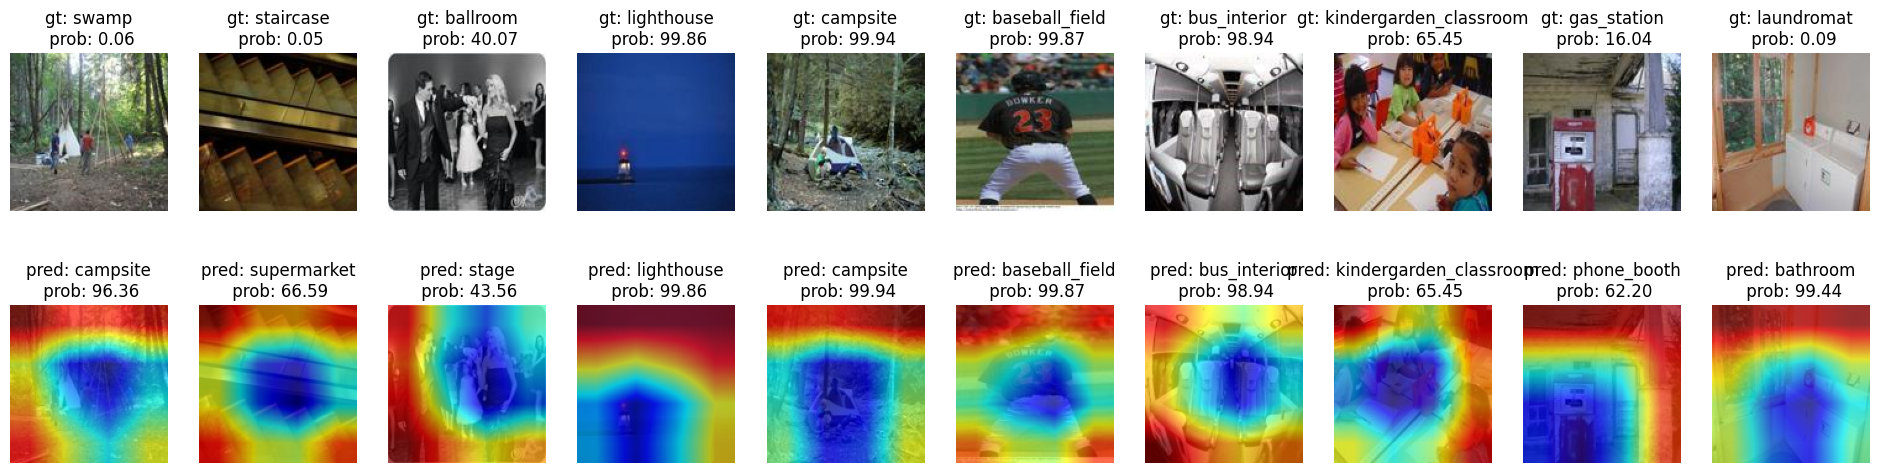

In [ ]:
import matplotlib.pyplot as plt

seed_everything(0)
resnet_finetune3.eval()

finalconv_name = 'layer4'
# hook the feature extractor
features_blobs = []


def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())


resnet_finetune3.resnet._modules.get(finalconv_name).register_forward_hook(
    hook_feature)

params = list(resnet_finetune3.parameters())
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

classes = []
for i in range(100):
    classes.append(str(i))

val_sub_dataset = torch.utils.data.Subset(
    miniplaces_val, np.random.choice(np.arange(len(miniplaces_val)), 10,
                                     False))
val_sub_loader = torch.utils.data.DataLoader(val_sub_dataset,
                                             batch_size=1,
                                             num_workers=num_workers,
                                             shuffle=False)

figure = plt.figure(figsize=(24, 6))
cols, rows = 10, 2
counter = 0

for i, data in enumerate(tqdm((val_sub_loader))):
    features_blobs = []
    img, label = data
    img = img.cuda()

    logit = resnet_finetune3(img)

    h_x = F.softmax(logit, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.cpu().numpy()
    idx = idx.cpu().numpy()

    # generate class activation mapping for the top1 prediction
    CAMs = CAM(features_blobs[0], weight_softmax, [idx[0]])

    img = img.squeeze().permute(1, 2, 0)
    height, width, _ = img.shape
    img = img.cpu() * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor(
        [0.485, 0.456, 0.406])
    img = img.cpu().numpy()
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0], (width, height)),
                                cv2.COLORMAP_JET)
    heatmap = heatmap / 255
    result = heatmap * 0.7 + img * 0.3

    figure.add_subplot(rows, cols, i + 1)
    plt.axis("off")
    plt.title(
        f"gt: {miniplaces_val.label_dict[label.item()]}\n prob: {h_x[label.item()].item()*100:.2f}"
    )
    plt.imshow(img, cmap="gray")

    figure.add_subplot(rows, cols, i + 11)
    plt.axis("off")
    plt.title(
        f"pred: {miniplaces_val.label_dict[idx[0]]}\n prob: {probs[0]*100:.2f}"
    )

    plt.imshow(result, cmap="gray")
    counter += 1

plt.show()

### Q2.4 Answer the following questions (15 pts)

a: Compare the results of using MLPs in Q3 of Assignment 1, FastConv in Q1, and ResNet in Q2. In 2-3 sentences, explain the differences in these model architectures and how such differences leads to the performance gap between these models. (5 pts)

Your Answer:  
Accuracies:  
MLP: ~14%   
FastConv: ~18%  
ResNet: ~36% (from scratch); ~50% (pre-trained)

The performance of the MLP was the worst since it simply used the images as inputs to the dense layers and thus the model wasn't able to learn more complex features. The FastConv used convolutional layers before the dense layers to extract feature maps which helped the model learn important features such as edges (spatial relationships), resulting in slightly improved performance. However ResNet had by far the best training accuracy not only because it's deeper than the other networks (enabled by residual learning) but it's also pre-trained, which allows us to get far better results with less training. This is because it has already learned important features from its original training.

---

b: Compare the results of Q2.1, Q2.2.2, Q2.2.3, Q2.2.4, and Q2.2.5? Why finetuning performs better than training from scratch on ResNet-18? Which finetuning techniques gives you the best accuracy? Which finetuning techniques gives you the worst accuracy? Use one sentence to explain the accuracy ordering for each finetuning method. (5 pts)

Your Answer:  
Accuracies:  
Scratch: 36%  
With linear classifier: 40%  
Finetune with same learning rate: 46%  
Finetune with different learning rates: 51%  
Finetune with a few frozen layers: 50%

Fine-tuning performs better than training from scratch as it takes advantage of pre-trained weights for features that the model has already learned from previous training. Then training on your task-specific data will tailor the model to the task at hand, resulting in better performance than starting with a blank slate.  

I got the best results from fine-tuning with different learning rates for the last dense layer and the rest of the layers because it allowed for the most nuanced learning where the intermediate layers could learn more complex features with a smaller learning rate.   
The next best result came from fine-tuning on all layers except a select few as althought it prevents the model from adapting some existing learned features to our data it allows the model to retain more of its pre-trained features.   
The worst performing model was the one where I used a single learning rate for all the layers, as this prevents some of the earlier layers from capturing more complex features in the input data when using the same learning rate as the last dense layer.

---

c: In 2-3 sentences, describe what you observe from the class activation mapping in Q2.3, where is the CNN "looking at" in those images? Give 1-2 examples from the visualizations. (5 pts)

Your Answer:  
The CNN seems to tend to focus on the center of the image, where there are a lot more varied pixel values and edges, as we can see in the gas station and laundromat images. It noticeably avoids the background such as in the lighthouse and campsite images. I believe this is likely the result of the model recognizing general edge features and that areas with diverse pixel values are likely to be the focus of the image.

---

## Q3: Your own model (20 pts)

In this question, you will train your own CNN on MiniPlaces. You can base your model on the pretrained `ResNet-18` weights, and modify the learning rate, optimizer, and other parameters during finetuning. You may also want to implement other training techniques such as data augmentation. But feel free to try other CNN architectures. You should write this model in the following code cells.

You will select the best model using the validation set, and then evaluate it on the test set.  You should create a file named "test_UID.json", containing "{id: predicted_label}" pairs. You may also try model assembly or test-time augmentation to further improve the performance.

You may also need to modify the previous MiniPlaces dataset to also load test images from `{root_dir}/images/test`.

We will hold a leaderboard of the test accuracy on [Kaggle](https://www.kaggle.com/t/5dfa88fa7eb94cb880cfbd1c9194352f). See the instructions on the website for submission to the leaderboard. The top 20% of students can receive a bonus. Don't worry, you shall receive a full credit for this question as long as your model has better accuracy than the finetuning baseline.

Feel free to organize your code in different ways. In this question, you do not have to follow the `#Your Implementations#` comments. Below is just an example of one possible organization for your code.

**Your code should be trainable on Colab**, we do not expect you to use additional resources to train your model, and your code should give similar test accuracies to the ones you posted on the leaderboard.

In [6]:
import torch
from PIL import Image
from torchvision import transforms

image_net_mean = torch.Tensor([0.485, 0.456, 0.406])
image_net_std = torch.Tensor([0.229, 0.224, 0.225])
# Define data transformation
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomCrop((128, 128)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.TrivialAugmentWide(),

    transforms.ToTensor(),
    transforms.Normalize(mean=image_net_mean, std=image_net_std),
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.CenterCrop((128, 128)),

    transforms.ToTensor(),
    transforms.Normalize(mean=image_net_mean, std=image_net_std),
])


In [7]:
from torch.utils.data import DataLoader, Dataset
import os

class MiniPlaces(Dataset):

    def __init__(self, root_dir, split, transform=None, label_dict=None):
        """
        Initialize the MiniPlaces dataset with the root directory for the images,
        the split (train/val/test), an optional data transformation,
        and an optional label dictionary.

        Args:
            root_dir (str): Root directory for the MiniPlaces images.
            split (str): Split to use ('train', 'val', or 'test').
            transform (callable, optional): Optional data transformation to apply to the images.
            label_dict (dict, optional): Optional dictionary mapping integer labels to class names.
        """
        assert split in ['train', 'val']
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.filenames = []
        self.labels = []

        self.label_dict = label_dict if label_dict is not None else {}

        self.root_dir = os.path.join(root_dir, 'images')
        file_path = os.path.join(root_dir, f'{split}.txt')
        with open(file_path, 'r') as file:
          for line in file:
            filename, label = line.strip().split()
            label = int(label)

            # Map label to class names (for training)
            if split == 'train':
              # Extract class name
              parts = filename.split('/')
              class_name = parts[2]
              if label not in self.label_dict:
                self.label_dict[label] = class_name
            else:
              # Map filenames to class names (for validation)
              if filename not in self.label_dict:
                self.label_dict[filename] = label


            self.filenames.append(filename)
            self.labels.append(int(label))

    def __len__(self):
            """
            Return the number of images in the dataset.

            Returns:
                int: Number of images in the dataset.
            """
            dataset_len = 0
            dataset_len = len(self.filenames)
            return dataset_len

    def __getitem__(self, idx):
        """
        Return a single image and its corresponding label when given an index.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            tuple: Tuple containing the image and its label.
        """
        image_path = os.path.join(self.root_dir, self.filenames[idx])
        image = Image.open(image_path)
        if self.transform is not None:
          image = self.transform(image)
        label = self.labels[idx]
        return image, label


data_root = os.path.join(root_dir, 'data')
# Create MiniPlaces dataset object
miniplaces_train = MiniPlaces(data_root,
                              split='train',
                              transform=train_transform)

miniplaces_val = MiniPlaces(data_root,
                            split='val',
                            transform=test_transform,
                            label_dict=miniplaces_train.label_dict)

# Create the dataloaders
# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Create DataLoader for training and validation sets
train_loader = DataLoader(miniplaces_train,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          shuffle=True)
val_loader = DataLoader(miniplaces_val,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=False)

In [8]:
def train(model, train_loader, val_loader, optimizer, criterion, device,
          num_epochs, ema_model=None, ema_step=None):
    """
    Train the MLP classifier on the training set and evaluate it on the validation set every epoch.

    Args:
        model (MLP): MLP classifier to train.
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        criterion (callable): Loss function to use for training.
        device (torch.device): Device to use for training.
        num_epochs (int): Number of epochs to train the model.
    """
    # Place model on device
    model = model.to(device)

    if ema_model is not None:
      ema_model = ema_model.to(device)

    step = 0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        # Use tqdm to display a progress bar during training
        with tqdm(total=len(train_loader),
                  desc=f'Epoch {epoch + 1}/{num_epochs}',
                  position=0,
                  leave=True) as pbar:
            for inputs, labels in train_loader:
                # Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out gradients
                optimizer.zero_grad()

                # Compute the logits and loss
                logits = model(inputs)
                loss = criterion(logits, labels)

                # Backpropagate the loss
                loss.backward()

                # Update the weights
                optimizer.step()

                if ema_model is not None and step % ema_step == 0:
                    ema_model.update_parameters(model)

                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())

                step += 1

                ema_model

        if ema_model is not None:
          ema_model.train()
          for inputs, _ in train_loader:
            inputs = inputs.to(device)
            with torch.no_grad():
              ema_model(inputs)

        # Evaluate the model on the validation set
        eval_model = ema_model if ema_model is not None else model
        avg_loss, accuracy = evaluate(eval_model, val_loader, criterion, device)
        print(
            f'Validation set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}'
        )


def evaluate(model, test_loader, criterion, device):
    """
    Evaluate the MLP classifier on the test set.

    Args:
        model (MLP): MLP classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.

    Returns:
        float: Average loss on the test set.
        float: Accuracy on the test set.
    """
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0

        for inputs, labels in test_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Compute the logits and loss
            logits = model(inputs)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Compute the accuracy
            _, predictions = torch.max(logits, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(inputs)


    # Compute the average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = num_correct / num_samples

    return avg_loss, accuracy

In [9]:
# Define your model.
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torch import nn


class ResNet50(nn.Module):

    def __init__(self, num_classes=100):
        super().__init__()

        self.resnet = models.resnet50(pretrained=True)

        # for param in self.resnet.parameters():
        #   param.requires_grad = False

        # # Unfreeze the last 100 layers
        # for param in self.resnet.layer4.parameters():
        #     param.requires_grad = True

        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)


    def forward(self, x):
        x = self.resnet(x)
        return x

    def to(self, device):
        return self.resnet.to(device=device)

In [12]:
# Train on the training set, validate on the validation set.
# Search hyper-parameters to find the best model on the validation set.

seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
resnet50_finetuned = ResNet50(num_classes=100)

weight_decay = 1e-5

lr = 1e-5
optimizer = torch.optim.Adam(resnet50_finetuned.resnet.parameters(), lr=lr, weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

# Train the model
train(resnet50_finetuned,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

Epoch 1/5: 100%|██████████| 1563/1563 [06:34<00:00,  3.96it/s, loss=2.69]


Validation set: Average loss = 2.1839, Accuracy = 0.4581


Epoch 2/5: 100%|██████████| 1563/1563 [06:24<00:00,  4.07it/s, loss=2.01]


Validation set: Average loss = 1.7863, Accuracy = 0.5223


Epoch 3/5: 100%|██████████| 1563/1563 [06:21<00:00,  4.09it/s, loss=2.36]


Validation set: Average loss = 1.6529, Accuracy = 0.5464


Epoch 4/5: 100%|██████████| 1563/1563 [06:22<00:00,  4.09it/s, loss=1.73]


Validation set: Average loss = 1.5810, Accuracy = 0.5605


Epoch 5/5: 100%|██████████| 1563/1563 [06:21<00:00,  4.10it/s, loss=2.04]


Validation set: Average loss = 1.5413, Accuracy = 0.5756


In [13]:
torch.save(resnet50_finetuned.state_dict(), 'resnet_weights1.pth')

In [15]:
# Define your model.
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torch import nn

class EfficientNet(nn.Module):

    def __init__(self, num_classes=100):
        super().__init__()

        self.enet = models.efficientnet_v2_s(pretrained=True)

        in_features = self.enet.classifier[-1].in_features
        self.enet.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features, num_classes)
        )


    def forward(self, x):
        x = self.enet(x)
        return x

    def to(self, device):
        return self.enet.to(device=device)

In [ ]:
from torch.optim.swa_utils import AveragedModel

# data augmentation
  # cropping
  # color changes
  # trivial augment
# adam
# L2 reg
# label smoothing
# moving avg


seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
enet_tuned = EfficientNet(num_classes=100)

weight_decay = 2e-5
norm_weight_decay = 0.0

norm_params = [param for name, param in enet_tuned.enet.named_parameters() if 'norm' in name]
other_params = [param for name, param in enet_tuned.enet.named_parameters() if 'norm' not in name]

parameters = [
    {"params": norm_params, "weight_decay": norm_weight_decay},
    {"params": other_params, "weight_decay": weight_decay}
]

lr = 1e-4
optimizer = torch.optim.Adam(parameters, lr=lr)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Train the model
train(enet_tuned,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=3)

Epoch 1/3: 100%|██████████| 1563/1563 [07:17<00:00,  3.57it/s, loss=2.7]


Validation set: Average loss = 2.0972, Accuracy = 0.5792


Epoch 2/3: 100%|██████████| 1563/1563 [08:01<00:00,  3.24it/s, loss=2.44]


Validation set: Average loss = 1.9629, Accuracy = 0.6162


Epoch 3/3: 100%|██████████| 1563/1563 [07:27<00:00,  3.50it/s, loss=2.1]


Validation set: Average loss = 1.9402, Accuracy = 0.6254


In [ ]:
torch.save(enet_tuned.state_dict(), 'enet_weights1.pth')

In [16]:
# Define your model.
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torch import nn
from functools import partial

class LayerNorm2d(nn.LayerNorm):
    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x = F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        x = x.permute(0, 3, 1, 2)
        return x

class ConvNeXt(nn.Module):

    def __init__(self, num_classes=100):
        super().__init__()

        self.cnext = models.convnext_small(pretrained=True)
        norm_layer = partial(LayerNorm2d, eps=1e-6)

        in_features = self.cnext.classifier[-1].in_features
        self.cnext.classifier = nn.Sequential(
            norm_layer(in_features),
            nn.Flatten(1),
            nn.Linear(in_features, num_classes)
        )


    def forward(self, x):
        x = self.cnext(x)
        return x

    def to(self, device):
        return self.cnext.to(device=device)

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
cnext_tuned = ConvNeXt(num_classes=100)

weight_decay = 2e-5
norm_weight_decay = 0.0

norm_params = [param for name, param in cnext_tuned.cnext.named_parameters() if 'norm' in name]
other_params = [param for name, param in cnext_tuned.cnext.named_parameters() if 'norm' not in name]

parameters = [
    {"params": norm_params, "weight_decay": norm_weight_decay},
    {"params": other_params, "weight_decay": weight_decay}
]

lr = 1e-4

optimizer = torch.optim.Adam(parameters, lr=lr)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Train the model
train(cnext_tuned,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/2: 100%|██████████| 1563/1563 [14:45<00:00,  1.77it/s, loss=1.87]


Validation set: Average loss = 1.8891, Accuracy = 0.6403


Epoch 2/2: 100%|██████████| 1563/1563 [14:45<00:00,  1.76it/s, loss=1.98]


Validation set: Average loss = 1.8449, Accuracy = 0.6557


In [ ]:
torch.save(cnext_tuned.state_dict(), 'cnext_weights1.pth')

In [ ]:
cnext_tuned2 = ConvNeXt(num_classes=100)

cnext_tuned2.load_state_dict(torch.load('cnext_weights1.pth'))

train(cnext_tuned2,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=1)

Epoch 1/1: 100%|██████████| 1563/1563 [14:10<00:00,  1.84it/s, loss=1.54]


Validation set: Average loss = 1.8449, Accuracy = 0.6557


In [ ]:
torch.save(cnext_tuned2.state_dict(), 'cnext_weights2.pth')

In [17]:
resnet50_finetuned = ResNet50(num_classes=100)
resnet50_finetuned.load_state_dict(torch.load('resnet_weights1.pth'))

enet_tuned = EfficientNet(num_classes=100)
enet_tuned.load_state_dict(torch.load('enet_weights1.pth'))

cnext_tuned = ConvNeXt(num_classes=100)
cnext_tuned.load_state_dict(torch.load('cnext_weights1.pth'))


extra = ConvNeXt(num_classes=100)
extra.load_state_dict(torch.load('cnext_weights2.pth'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 158MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up

<All keys matched successfully>

In [18]:
models = [resnet50_finetuned.to(device), cnext_tuned.to(device), enet_tuned.to(device), extra.to(device)]

In [19]:
# Build train/val/test datasets and data loaders using the modules we built before.

class MiniPlacesTest(Dataset):

    def __init__(self, root_dir, transform):
        """
        Initialize the MiniPlaces test dataset with the root directory for the images,
        an optional data transformation,


        Args:
            root_dir (str): Root directory for the MiniPlaces images.
            transform (callable, optional): Optional data transformation to apply to the images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.filenames = []
        self.ids = []

        # You should read the test images from '${root_dir}/images/test' dir and save their filepaths and ids
        # For instance: the id of image 'test/00000001.jpg' should be '00000001' in string
        ################# Your Implementations #################################
        self.root_dir = os.path.join(root_dir, 'images/test')

        for imfile in os.listdir(self.root_dir):
          id = os.path.splitext(imfile)[0]
          self.ids.append(id)
          self.filenames.append(os.path.join(self.root_dir, imfile))
        ################# End of your Implementations ##########################

    def __len__(self):
        """
        Return the number of images in the dataset.

        Returns:
            int: Number of images in the dataset.
        """
        dataset_len = 0
        ################# Your Implementations #################################
        # Return the number of images in the dataset
        dataset_len = len(self.filenames)
        ################# End of your Implementations ##########################
        return dataset_len

    def __getitem__(self, idx):
        """
        Return a single image and its corresponding id when given an index.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            tuple: Tuple containing the image and its id.
        """
        ################# Your Implementations #################################
        # Load and preprocess image using self.root_dir,
        # self.filenames[idx], and self.transform (if specified)
        image_path = self.filenames[idx]
        image = Image.open(image_path)
        if self.transform is not None:
          image = self.transform(image)
        id = self.ids[idx]
        ################# End of your Implementations ##########################
        return image, id


data_root = os.path.join(root_dir, 'data')
# Create MiniPlaces test dataset object
miniplaces_test = MiniPlacesTest(data_root, transform=test_transform)

# Create DataLoader for test set
test_loader = DataLoader(miniplaces_test,
                         batch_size=batch_size,
                         num_workers=num_workers,
                         shuffle=False)

In [20]:
# Generate test-set results.


def test(models, test_loader):
    """
    Evaluate the MLP classifier on the test set.

    Args:
        model (MLP): MLP classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.

    Returns:
        out_dict: prediction result on the test set
    """
    for model in models:
      model.eval()  # Set model to evaluation mode

    out_dict = {}

    with torch.no_grad():
      for inputs, ids in test_loader:
          ################# Your Implementations #############################
          # similar to the evaluate function
          # first compute the output logits and then get the predicted class with maximum probability
          # save the id and the prediction to out_dict
          inputs = inputs.to(device)
          sum_logits = None

          for model in models:
            logits = model(inputs)
            probabilities = torch.softmax(logits, dim=1)

            if sum_logits is None:
              sum_logits = probabilities
            else:
              sum_logits += probabilities

          avg_probabilities = sum_logits/len(models)
          _, ensemble_predictions = torch.max(avg_probabilities, dim=1)
          # _, predictions = torch.max(logits, dim=1)

          for id, prediction in zip(ids, ensemble_predictions):
            out_dict[id] = prediction.item()
            ################# End of your Implementations ######################
    return out_dict

In [21]:
# Convert the test-set results dictionary to a CSV file:

import csv

test_output = test(models, test_loader)
assert len(test_output) == 10000
# update your csv file name for submissioin
csv_name = "test.csv"

# now we will open a file for writing
data_file = open(os.path.join(root_dir, csv_name), 'w')

# create the csv writer object
csv_writer = csv.writer(data_file)

# Counter variable used for writing
# headers to the CSV file
count = 0

header = ['Id', 'Category']

for key, value in test_output.items():
    if count == 0:
        # Writing headers of CSV file
        header = header
        csv_writer.writerow(header)
        count += 1

    # Writing data of CSV file
    csv_writer.writerow([key, str(value)])

data_file.close()
print("succesfully saved the test csv file at: " +
      os.path.join(root_dir, csv_name))

from google.colab import files

files.download(os.path.join(root_dir, csv_name))

succesfully saved the test csv file at: ./CS188_W24/Assignment2/test.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Please report your test accuracy on the public leaderboard:

(Double click to edit)

Your Answer:  
65.8%

---

In one paragraph, shortly summarize your method and your improvement and modifications made upon the baseline:

(Double click to edit)

Your Answer:  
I essentially used the ResNet50 model instead of ResNet18, since I intuited that a deeper network would be able to ultimately perform better in learning complex features (despite the computational tradeoff). I also made the learning rate lower than the default (found through trial and error) to avoid inefficient gradient steps and I also used the Adam optimizer. This way my learning rate would adapt to the progress of the gradient descent, combining the benefits of 1st and 2nd moments. I also used a weight_decay (L2 regularization) to help penalize larger weights and thus reduce the chance of overshooting a local minima in training.

---